# Assignment 7: Neural networks

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

# General instructions

1. Do not remove any text or code cells; do not leave redundent print messages.
1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 3 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. Your code should run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, numba, multiprocessig.
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment7"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Cloud computing with GPU

**In Ex 2 and Ex 3 there is a benefit in running on a computer with a GPU. There are two ways to do that:**
1. Use [**Google Colaboratory**](http://colab.research.google.com) (free.) Colaboratory provides free GPU usage for 12 hours inside a Jupyter notebook. Once you are inside colaboratory, upload this notebook, and change the runtime to Python 3 + GPU. Don't forget to download your notebook when you finish (from the File menu), although it will be saved in your Google Docs.

1. Use **AWS Educate**. You can sign up for an AWS Educate account without a credict card, and get some free credits to use for AWS services. You can get an additional \$50 for this course - just ask for it on Piazza and allow for 24 hrs.
[Instructions are provided](https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/) for setting up a deep learning environment with conda, jupyter, and keras. Note that when you go over the credit limit (\$50) your account will be suspended and you will not have access to your work, so plan accordingly. Some GPU-enabled instances estimated  costs are: p2.xlarge (Tesla K80) 22 USD/day; p3.2xlarge (2 x Tesla v100) 75 USD/day; p3.16xlarge (8 x Tesla v100) 600 USD/day. At this stage you should probably take the cheapest one.

It may be worth the effort: epochs on the dataset used in Ex 2 and Ex 3 take about 15 secs on colaboratory, compared to 40 secs on my laptop. 
But it is not mandatory to work with a GPU, you can use your local CPU.

In [1]:
###
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import scipy.stats
import seaborn as sns
sns.set_context('notebook')

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
###
# this code is required for Ex 1
def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
def fully_connected(ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return np.random.uniform(-boundary, boundary, size=(ninputs, noutputs))

def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

def ReLU(X):
    return np.maximum(X, 0)

def dReLU(X):
    return (X > 0).astype(float)

def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

def predict(Ws, X):
    if X.ndim == 1:
        X = X.reshape((1, -1))
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx])

def loss(Ws, X, Y):
    Yhat = predict(Ws, X)
    return cross_entropy(Yhat, Y)

def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y, keep_prob=1)
    Ws_ = [W.copy() for W in Ws]

    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)
                    
def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates
    
def trainer(Ws, X, Y, optimizer, batch_size=50, keep_prob=1):    
    nsamples = X.shape[0]
    batch = 0
    while True:
        # get next batch
        start = (batch * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = range(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        
        gradients = back_propagation(Ws, X_, Y_, keep_prob=keep_prob) # calculate gradients
        
        ΔWs = optimizer.send(gradients) # calculate updates
        
        for W, ΔW in zip(Ws, ΔWs): # apply updates
            W += ΔW
            
        batch += 1
        yield batch

# Ex 1

Let's load the data for MNIST digits.

In [3]:
###
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
# print(keras.datasets.mnist.load_data())
print(X_train[1])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 252 252  96 189 253 167   

**Implement `feed_forward` and `back_propagation` from the FFN lecture using a `for` loop so that they work for any number of hidden layers.**

Notes: 
- when implementing `back_propagation`, you can use the `gradient_check` function (from `A5.py`) to test that it works as expected.
- please keep the functions signatures as supplied.

In [5]:
print((X_train, Y_train), (X_test, Y_test))
print(ncats)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)) (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))
10


In [6]:
def feed_forward(Ws, X, keep_prob=1): ###
    network = [X]
    W_hidden = Ws[:-1] # All but last Ws
    W_final = Ws[-1] # Last Ws
    
    for i, W in enumerate(W_hidden): # For all Ws of the hiddle layer
        # For each layer
        X = X @ W              # Computing dot product
        X = drop(X,keep_prob)
        X = ReLU(X)
        network.append(X)      # Add layer
  
    # For the last layer   
    X = X @ W_final   
#     X = drop(X, keep_prob=keep_prob)
    X = softmax(X) 
    network.append(X)      # Add layer

    return network

In [7]:
def back_propagation(Ws, X, Y, keep_prob=1): ###
    layers = feed_forward(Ws, X, keep_prob=keep_prob) # X1, Z1, X2, Z2, Yhat
    gradients = []

    # In backprop we start with the last layer
    layer = layers.pop() 
#     print('Layers.pop {}\n'.format(layer.shape))
#     print('Y {} \n'.format(Y.shape))

    delta = layer - Y # we dont want to consider target values
#     print(Y)

    Ws_num = len(Ws)+1 # We want to go over all the layer weights +1

    for i in range(1,Ws_num):
        # We start by getting the gradient
        Z = layers.pop() # Current layer (will iterate as we iterate over range)
        Z_transpose = Z.T
        gradients.append(Z_transpose @ delta)  #adding the gradients of Z

        if i == (Ws_num - 1):
            break
       
        # Now we are calculating the cost

        # Take the ith layer from the back (because in backprop we start with the last layer)
        W_transpose = Ws[-i].T
        delta = (delta @ W_transpose) * dReLU(Z)  # δ = δ • W * ReLU(Z)
    # change order
    gradients.reverse()
    # sanity checks (From class)
    assert len(gradients) == len(Ws), (len(gradients), len(Ws))
    for dW, W in zip(gradients, Ws):
        assert dW.shape == W.shape, (dW.shape, W.shape)
    return gradients

Now **train the FFN model** with 2 or more hidden layers, and print its accuracy on the test set.

I was able to achieve 0.93 test accuracy with about 7-8 seconds of training.

In [15]:
X_train.shape[1]

784

In [17]:
### change the ?s
nhidden =784
l1, l2 = 100, 50

W1 = fully_connected(nhidden, l1)
W2 = fully_connected(l1, l2)
W3 = fully_connected(l2, 10)
Ws = [W1, W2, W3]

batch_size = 100
train = trainer(Ws, X_train, Y_train, batch_size=batch_size, optimizer=AdamOptimizer())

In [18]:
acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy: {:.4f}".format(acc))

Accuracy: 0.0606


In [19]:
### change the ?s
epochs = 10
for batch in train:
    if batch == epochs * nsamples // batch_size: break

acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy ({:d}): {:.4f}".format(batch, acc))
% time

Accuracy (6000): 0.9608
CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 6.68 µs


# Ex 2

## Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) (MS deep learning package), or [Theano](http://www.deeplearning.net/software/theano/).

The main benefit is that it *allows for easy and fast prototyping*.

Since version 1.4 of TensorFlow, Keras is installed with TensorFlow as a high-level interface to TensorFlow.

## Fashion-MNIST datasetset

The Fashion-MNIST dataset contains 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:


| Label |	Description|
|---|------------------|
| 0 |	T-shirt/top    |
| 1 |	Trouser        |
| 2 |	Pullover       |
| 3 |	Dress          |
| 4 |	Coat           |
| 5 |	Sandal         |
| 6 |	Shirt          |
| 7 |	Sneaker        |
| 8 |	Bag            |
| 9 |	Ankle boot     |

See more information on this dataset in the [keras docs](https://keras.io/datasets/).

In this exercise we will use Keras to train a neural network on the dataset. 

In [1]:
###
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

Keras 2.3.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using TensorFlow backend.


GPU: True
/device:GPU:0


In [2]:
###
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


We need to convert the images to a float32 between 0 and 1 and reshape to 28x28x1 (only one channel for black and white) because 2D convolutions expect 3D images (3rd dimension is channel or image).

We also need to one-hot encode the labels, and to scale the data from 0-255 to 0-1.

In [3]:
###
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Let's see the images.

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


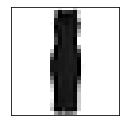

In [4]:
###
i = np.random.randint(0, x_train.shape[0])
plt.figure(figsize=(2,2))
plt.imshow(x_train[i, :, :, 0], cmap='gray_r')
plt.xticks([]); plt.yticks([])
print(y_train[i])

## Using Keras

A Keras model can be built by defining the model layers, then giving them to the `Sequential` model object.
You could also first create the model object and the use its `add` method to add layers.

A `Dense` layer uses matrix muliplication. We need to provide it with the number of outputs, in this case the number of categories, and the activation function, in this case the softmax function.

A `Flatten` layer just flatten the input data - turns it into a 1D array.
The first layer always has to be told the shape of the input (`X`) using `input_shape`.

```python
layers = [
    keras.layers.LayerName(arguments),
    ...
]
model = keras.models.Sequential(layers)
```

After defining the network, we can print a summary using `model.summary()`.
Then, we need to compile the Keras model (which creates the underlying TensorFlow network) and configuring it for training.
At this stage we can choose the [loss function](https://keras.io/api/losses/), the [optimizer](https://keras.io/api/optimizers/), and additional [metrics](https://keras.io/api/metrics/) we with to collect, such as accuracy.

```python
model.compile(
    loss=...,
    optimizer=...,
    metrics=[...]
)
```

After compiling the network, we are ready to train it by giving it the train and test datasets:
Training is done by calling the `fit` method of the model object
```python
model.fit(
    x_train, y_train,
    batch_size=...,
    epochs=...,
    validation_data=(x_test, y_test)
)
```

The `fit` method retuns a `history` object that can be used to plot the accuracy and loss over time (see plot below).

**Build, train, and score a neural network**. 

You can use a feed forward network, or you can use a more sophisticated approach with a convolutional neural network (CNN). Or try both.
As long as you reach a high enough accuracy (>80%) it is fine.

In [25]:
# Building the NN

In [32]:
#initializing the model
# model = Sequential()
input_shape = (28, 28, 1)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [33]:
#To visualize neural network
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [30]:
# Training the NN

In [35]:
history = model.fit(x_train, 
                    y_train,
                    epochs=10, 
                    batch_size=100,
                    validation_data=(x_test, y_test)
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.5822 - accuracy: 0.7963 - val_loss: 0.4630 - val_accuracy: 0.8400
Epoch 2/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.4022 - accuracy: 0.8572 - val_loss: 0.4252 - val_accuracy: 0.8494
Epoch 3/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.3649 - accuracy: 0.8695 - val_loss: 0.3837 - val_accuracy: 0.8638
Epoch 4/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.3390 - accuracy: 0.8780 - val_loss: 0.3908 - val_accuracy: 0.8617
Epoch 5/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.3214 - accuracy: 0.8844 - val_loss: 0.3723 - val_accuracy: 0.8656
Epoch 6/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.3098 - accuracy: 0.8862 - val_loss: 0.3686 - val_accuracy: 0.8674
Epoch 7/10
60000/60000 [==============================] - 2s 38us/st

In [26]:
# Scoring the NN

In [36]:
### score trained model
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

10000/10000 [==============================] - 1s 52us/step
Test loss: 0.3519650325059891
Test accuracy: 0.8726999759674072


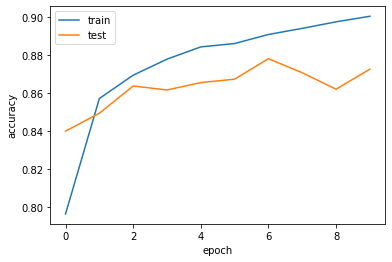

In [37]:
### plot accuracy over training time
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
### score trained model
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

10000/10000 [==============================] - 0s 33us/step
Test loss: 0.36533783659935
Test accuracy: 0.8720999956130981


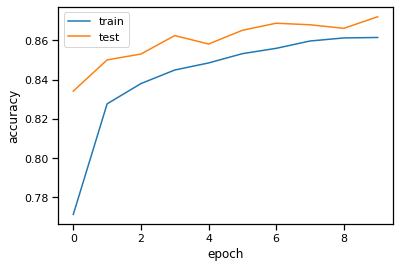

In [ ]:
### plot accuracy over training time
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

**end of assignment**